# Introduction

This project implements a long/short equity mean reversion strategy using Python and Zipline. The aim is to systematically identify and capitalize on market anomalies by selecting stocks that deviate from their historical returns, and betting on their mean reversion. Throughout this notebook, I build a custom factor model, construct automated pipelines for stock selection, and execute disciplined portfolio management—all against a backdrop of realistic trading costs and constraints. I aim to analyse the performance of the strategy and improvements I can make along the way. This is still a work in progress thus I may make more changes in the future.

## Data Ingestion and Preparation

Before any quantitative strategy can be tested, reliable market data needs to be properly ingested and structured for analysis. In this project, I use Zipline’s ingestion pipeline to fetch, clean, and store historical financial data from Quandl. While Quandl has been deprecated since 2021 I still used this as I had problems working with yfinance and polygon bundles but had several errors that I have yet to attempt fixing. The problem with working with Quandl is that I can only use outdated data (as for this project, using data from 2016 to 2018 only). 

The presence of an API key is asserted to ensure secure access. This workflow guarantees all simulations downstream are built on a foundation of consistent, reproducible market data.

In [5]:
from zipline.data.bundles.core import load
from zipline.data.bundles import ingest
from dotenv import load_dotenv
import os

load_dotenv()
assert os.getenv("QUANDL_API_KEY"), "Missing QUANDL API KEY"
ingest("quandl")
bundle = load("quandl", os.environ, None)

c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\zipline\data\bundles\quandl.py:107: FutureWarning: The provided callable <function amin at 0x000001A454FEE170> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\zipline\data\bundles\quandl.py:107: FutureWarning: The provided callable <function amax at 0x000001A454FEDFC0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\zipline\data\bcolz_daily_bars.py:341: UserWarning: Ignoring 1 values because they are out of bounds for uint32:
   

## Core Research Libraries

Here, I set up the project’s computational environment using essential Python, Zipline, and data science libraries. Pandas and NumPy are leveraged for high-performance data manipulation and analytics, Zipline powers the backtesting and strategy simulation engines, and Pandas DataReader is used to pull benchmark data (S&P500). This toolkit supports the flexibility needed to experiment with custom factors, feature engineering, and portfolio optimization at a research level.

In [6]:
import pandas as pd
import numpy as np
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.finance import commission, slippage
from zipline.api import (
    attach_pipeline,
    calendars,
    pipeline_output,
    date_rules,
    time_rules,
    set_commission,
    set_slippage,
    record,
    order_target_percent,
    get_open_orders,
    get_datetime,
    schedule_function
)
import pandas_datareader as web

## Custom Mean Reversion Factor Construction

To capture meaningful investment signals, I define a custom factor called MeanReversion based on rolling window returns. For each asset, this factor measures how abnormally it has moved relative to its history, using z-scores on monthly returns across a year. The use of custom factors allows me to tailor the quant research to specific hypotheses about market behavior and risk, laying the groundwork for systematic stock selection rooted in mathematical insight.

In [7]:
# Number of long and short positions to hold
N_LONGS = N_SHORTS = 50
# Approximate number of trading days in a month and year
MONTH = 21
YEAR = 12 * MONTH

# Custom mean reversion factor using Zipline Pipeline
class MeanReversion(CustomFactor):
    # Use rolling monthly returns as input
    inputs = [Returns(window_length=MONTH)]
    # Look back over a year of monthly returns
    window_length = YEAR
    def compute(self, today, assets, out, monthly_returns):
        # Convert input array to DataFrame for easier manipulation
        df = pd.DataFrame(monthly_returns)
        # Calculate z-score: (last month's return - mean) / std deviation
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

## Pipeline Architecture

An automated pipeline is essential for systematic trading—it enables real-time, scalable factor calculation and asset selection. In this section, I assemble a Zipline Pipeline that chooses the 100 most liquid stocks and applies the mean reversion factor to identify long and short candidates. This approach models the core logic of institutional quant desks: robust, consistent screening using relevant, data-driven metrics that translate easily into trading decisions.

In [8]:
# Build the pipeline for stock selection
def make_pipeline():
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(
        columns={
            # Select bottom N_LONGS for long positions (most negative z-scores)
            "longs": mean_reversion.bottom(N_LONGS),
            # Select top N_SHORTS for short positions (most positive z-scores)
            "shorts": mean_reversion.top(N_SHORTS),
            # Rank all assets by mean reversion score (descending)
            "ranking": mean_reversion.rank(),
        },
        # Only consider the 100 most liquid stocks by dollar volume
        screen=dollar_volume.top(100)
    )

## Key Zipline Steps

1. `before_trading_start(context, data)`

Before the start of each trading session, I update the pipeline factors to reflect the latest market conditions. This step ensures that portfolio construction and trade signals are always based on the most current analysis, helping to minimize alpha decay and allowing the strategy logic to respond to changing regimes with agility.

2. `initialize(context)`

The function in Zipline serves as the entry point for setting up the trading algorithm's environment. It's purpose is to define and configure all the inital states and parameters before the backtest or live simulation begins.

In here, `initialize(context)` does several things:
* **Attaches the Pipeline**: It links the custom pipeline (see `make_pipeline()` above) to the trading algorithm so these signals can be used during each trading session.
* **Schedules Functions**: It sets up a daily schedule (this can be changed to weekly, monthly, etc,) to rebalance the portfolio shortly after the market opens (this can be changed to market close, specific minutes after market open, after close, etc.), ensuring that the trading logic runs consistently.
* **Configures Trading Costs**: It defines transaction cost models (per-share commission and volume-based slippage) to simulate realistic trading environments, which is crucial for accurately estimating strategy profitability and risk. 
* **Sets the Market Calendar**: It specifies the appropriate trading calendar (US equities) so that all rebalancing and analysis align with actual market open/close times.

3. `rebalance(context, data)`

The rebalance function in Zipline is the core trading logic that determines how the portfolio should be adjusted based on updated signals.

Specifically, it:
* Retrieves the latest factor data (e.g. stock ranking, long/short signals) stored in the context.
* Identifies which assets to hold long positions in and which to short, based on the pipeline output.
* Detects any current holdings that are no longer in the new long or short lists. These positions are divested.
* Places orders to adjust the portfolio so that each long position is equally weighted at $\frac{1}{N_{LONG}}$ and each short at $-\frac{1}{N_{SHORT}}$, maintaining market neutrality.
* Records relevant statistics such as ranking and prices for diagnostics or analysis.
* Prints portfolio metrics such as portfolio value and the count of long/short holdings to trace performance during the backtest.

4. `exec_trades(data, assets, target_percent)`

The function is a utility that places orders to adjust the portfolio to the desired target allocations. For each asset in the given list, it:

* Checks if the asset is tradable at the current time using `data.can_trade(asset)`. This ensures that orders are only sent on assets that are currently active and eligible for trading.
* Checks if there are no open orders already pending for the asset using `get_open_orders(asset)`. This prevents sending duplicate or conflicting orders before previous ones are filled.
* If both conditions pass, it places an order to adjust the position to the `target_percent` specified, which is a percentage of the portfolio value.

Explanation of Zipline API Methods:
* `can_trade(asset)`: Returns `True` if the asset can be traded at the current minute according to exchange hours and market conditions, otherwise `False`. This prevents placing orders outside of valid trading times.
* `get_open_orders(asset)`: Returns any currently open (unfilled) orders for the specified asset. This allows the algorithm to avoid sending multiple simultaneous orders for the same security that could lead to overtrading or errors.
In summary, `exec_trades` is the disciplined order execution component that carefully sends trade instructions only when appropriate and avoids overlapping orders, ensuring orderly portfolio management in sync with the trading logic.

5. `analyze(context, perf)`

This function runs after the backtest completes. It plots the evolution of the portfolio's value over time, giving a quick visual of overall performance and drawdowns across the backtest period. The function has to be defined as a parameter for the `run_algorithm` function discussed after this.

In [30]:
# Called before each trading day to get the latest pipeline output
def before_trading_start(context, data):
    # Store pipeline results in context for use in rebalancing
    context.factor_data = pipeline_output("factor_pipeline")

# Initialize the algorithm and set up schedules, commission, and slippage
def initialize(context): 
    # Attach the pipeline to the algorithm
    attach_pipeline(make_pipeline(), "factor_pipeline")
    # Schedule weekly rebalancing at market open
    schedule_function(
        rebalance,
        date_rules.month_end(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )
    # Set commission model (per share)
    set_commission(
        us_equities=commission.PerShare(cost=0.00075, min_trade_cost=0.01)
    )
    # Set slippage model (volume share based)
    set_slippage(
        us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01)
    )

# Rebalance portfolio based on pipeline output
def rebalance(context, data):
    factor_data = context.factor_data
    # Record the ranking for later analysis (note: record expects scalars)
    record(factor_data=factor_data.ranking)
    assets = factor_data.index
    # Record average price for diagnostics
    record(prices=data.current(assets, "price"))
    # Select assets to long and short
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    # Find assets to fully exit (not in new long/short lists)
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    # Print current date, number of longs/shorts, and portfolio value
    print(f"{get_datetime().date()} | Longs {len(longs)} | Shorts {len(shorts)} | {context.portfolio.portfolio_value}")
    # Sell all divested assets
    exec_trades(data, assets=divest, target_percent=0)
    # Set target weights for longs and shorts (currently 100% each; consider splitting weights for neutrality)
    exec_trades(data, assets=longs, target_percent=100/N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-100/N_SHORTS)

# Helper function to place orders for a list of assets
def exec_trades(data, assets, target_percent):
    for asset in assets:
        # Only trade if asset is tradable and no open orders exist
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

# Plot portfolio value at the end of the backtest
def analyze(context, perf):
    perf.portfolio_value.plot()

## Backtest Analysis and Execution

Here I define the period of backtest to be from 2016 to 2018. As mentioned earlier, I really wished I could use more recent data but the Quandl bundle does not have data after 2020. I tried using other bundles, first with yahoo finance but ran into several errors that I was unable to fix, and then tried the Polygon bundle that had issues with authentication (consistently ran into a 403 error). 

`benchmark_returns` fetches the S&P500 index data from the FRED database for the same period, then calculates daily percentage returns to serve as a benchmark. This allows performance comparison between the strategy and the broader market.

`run_algorithm` is Zipline's main execution function that launches tha backtest using all previous settings:
* Runs from the specified start to end date
* Uses the `initialize`, `before_trading_start`, and `analyze` functions to manage state, update signals, and plot results.
* Applies realistic capital constraints and market calendars
* Uses the Quandl data bundle for historic prices
* incorporates benchmark returns for performance attribution

`to_pickle` saves the final performance object (`perf`) to a pickle file named `mean_reversion.pickle` for later retrieval and detailed analysis.

C:\Users\nickt\AppData\Local\Temp\tmpzme4hp9l\ipykernel_6452\1976952203.py:13: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  benchmark_returns = sp500.pct_change().dropna()


2016-01-29 | Longs 2 | Shorts 4 | 100000.0
2016-02-29 | Longs 1 | Shorts 0 | 107679.9343013863
2016-03-31 | Longs 1 | Shorts 0 | 104577.71358008016
2016-04-29 | Longs 3 | Shorts 0 | 148749.24872377684
2016-05-31 | Longs 1 | Shorts 2 | 186216.63407479913
2016-06-30 | Longs 1 | Shorts 2 | 225405.9074286684
2016-07-29 | Longs 0 | Shorts 2 | 255014.12326252577
2016-08-31 | Longs 4 | Shorts 0 | 239965.47334700276
2016-09-30 | Longs 2 | Shorts 0 | 180959.1786580768
2016-10-31 | Longs 2 | Shorts 4 | 199164.5938475111
2016-11-30 | Longs 5 | Shorts 1 | 166935.5492641006
2016-12-30 | Longs 1 | Shorts 0 | 225380.02306303172
2017-01-31 | Longs 1 | Shorts 3 | 226614.7087393241
2017-02-28 | Longs 2 | Shorts 6 | 227854.83419089502
2017-03-31 | Longs 3 | Shorts 0 | 206963.20840494405
2017-04-28 | Longs 2 | Shorts 1 | 243552.1928484278
2017-05-31 | Longs 1 | Shorts 3 | 183075.33465033985
2017-06-30 | Longs 7 | Shorts 4 | 291105.5095139232
2017-07-31 | Longs 2 | Shorts 6 | 363233.3636797592
2017-08-31 |

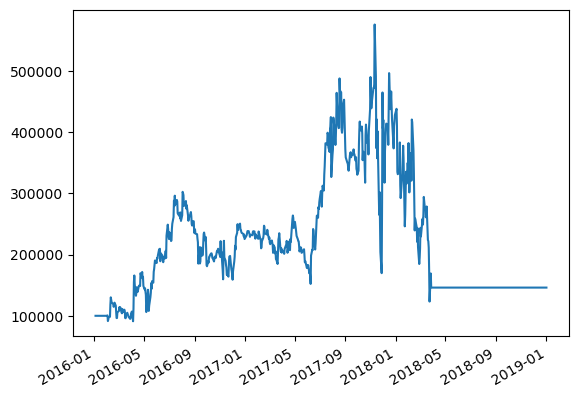

In [39]:
import pandas as pd
from pandas_datareader import data as web
import pytz

# Set up backtest parameters
start = pd.Timestamp("2016-01-01")
end = pd.Timestamp("2018-12-31")

# Get S&P 500 index data from FRED for benchmark returns
sp500 = web.DataReader('SP500', 'fred', start, end).SP500

# Calculate daily returns
benchmark_returns = sp500.pct_change().dropna()

# Normalize timezone of benchmark_returns index (make tz-naive)
benchmark_returns.index = benchmark_returns.index.tz_localize(pytz.UTC)

# Run the backtest with all the above settings
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    benchmark_returns=benchmark_returns,
    before_trading_start=before_trading_start,
    capital_base=100_000,
    bundle="quandl"
)

# Save results to a file for later analysis
perf.to_pickle("mean_reversion.pickle")


c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '125.38%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-19.563%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\pyfolio\plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '13.503%' has d

KeyError: "[Timestamp('2016-01-04 00:00:00+0000', tz='UTC')] not in index"

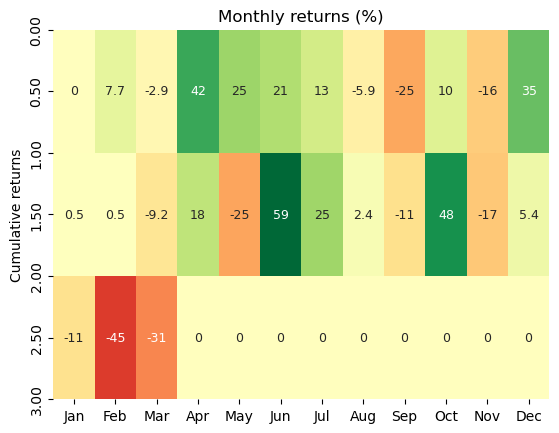

In [40]:
import pyfolio as pf
import pandas as pd

perf = pd.read_pickle('mean_reversion.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

# Normalize indices to timezone-naive immediately after loading/extracting
live_start_date = pd.Timestamp("2017-01-01").tz_localize(pytz.UTC)

pf.plotting.show_perf_stats(
    returns,
    factor_returns=benchmark_returns,
    positions=positions,
    transactions=transactions,
    live_start_date=live_start_date
)
pf.plotting.plot_monthly_returns_heatmap(returns)
pf.plotting.plot_rolling_returns(returns, factor_returns=benchmark_returns)
